In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.layers import LSTM, Dense, Dropout, MultiHeadAttention, LayerNormalization


In [2]:
! pip install mplfinance
! pip install pandas_ta

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=faf4852ed1680c5686287fae15c653ba6cbe301b86f0c51cc7a77917b0b7c15a
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [3]:
data = pd.read_csv('/kaggle/input/eurusd/EURUSD-30-DS.csv', header=None, names=['Date','Open', 'High', 'Low', 'Close','Volume'])
data.head()

,Date,Open,High,Low,Close,Volume
0,01.01.2008 02:00:00.000,1.45841,1.45982,1.45770,1.45937,6473.2500
1,01.01.2008 02:30:00.000,1.45965,1.45982,1.45768,1.45785,6484.6000
2,01.01.2008 03:00:00.000,1.45788,1.45803,1.45761,1.45784,4957.6000
3,01.01.2008 03:30:00.000,1.45788,1.45794,1.45754,1.45770,3416.5500
4,01.01.2008 04:00:00.000,1.45770,1.45983,1.45766,1.45954,5553.4375


In [4]:
import pandas_ta as ta
data['RSI_14'] = ta.rsi(data['Close'], length=14)
data['RSI_7'] = ta.rsi(data['Close'], length=7)
data['RSI_20'] = ta.rsi(data['Close'], length=20)
data['MA20'] = ta.ema(data['Close'], length=20)
data['MACD'] = ta.macd(data['Close'])['MACD_12_26_9']
data['ATR'] = ta.atr(data['High'], data['Low'], data['Close'], length=14)
bb = ta.bbands(data['Close'], length=20)
data['BB_upper'] = bb['BBU_20_2.0']
data['BB_lower'] = bb['BBL_20_2.0']
data['Stoch_K'] = ta.stoch(data['High'], data['Low'], data['Close'])['STOCHk_14_3_3']
data['Candle_Range'] = data['High'] - data['Low']
data['Candle_Body'] = data['Close'] - data['Open']


data['Average'] = ((data['Open'] + data['Close'] + data['High'] + data['Low']) / 4)
data = data.dropna()

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


In [5]:
data.head(7)

,Date,Open,High,Low,Close,Volume,RSI_14,RSI_7,RSI_20,MA20,MACD,ATR,BB_upper,BB_lower,Stoch_K,Candle_Range,Candle_Body,Average
25,01.01.2008 14:30:00.000,1.45891,1.45915,1.45847,1.45880,18006.2910,47.685991,47.823801,47.680448,1.458881,-0.000093,0.000895,1.459921,1.458140,32.524272,0.00068,-0.00011,1.458832
26,01.01.2008 15:00:00.000,1.45883,1.45904,1.45828,1.45853,19194.9815,44.445352,40.173630,45.267104,1.458847,-0.000110,0.000884,1.459921,1.458087,28.964401,0.00076,-0.00030,1.458670
27,01.01.2008 15:30:00.000,1.45867,1.45899,1.45844,1.45872,21040.4470,47.166330,47.118547,47.245023,1.458835,-0.000107,0.000856,1.459918,1.458069,32.069953,0.00055,0.00005,1.458705
28,01.01.2008 16:00:00.000,1.45877,1.45918,1.45846,1.45875,23042.9375,47.602711,48.225688,47.559992,1.458827,-0.000101,0.000845,1.459798,1.458086,36.295565,0.00072,-0.00002,1.458790
29,01.01.2008 16:30:00.000,1.45893,1.45903,1.45844,1.45873,21636.3940,47.322095,47.452975,47.361558,1.458818,-0.000097,0.000825,1.459699,1.458096,47.385701,0.00059,-0.00020,1.458782
30,01.01.2008 17:00:00.000,1.45880,1.45925,1.45835,1.45862,23293.6500,45.725529,43.029015,46.244509,1.458799,-0.000101,0.000831,1.459656,1.458074,48.338577,0.00090,-0.00018,1.458755
31,01.01.2008 17:30:00.000,1.45879,1.45927,1.45823,1.45897,23591.1940,51.349816,57.676209,50.180024,1.458815,-0.000076,0.000847,1.459663,1.458079,56.433815,0.00104,0.00018,1.458815


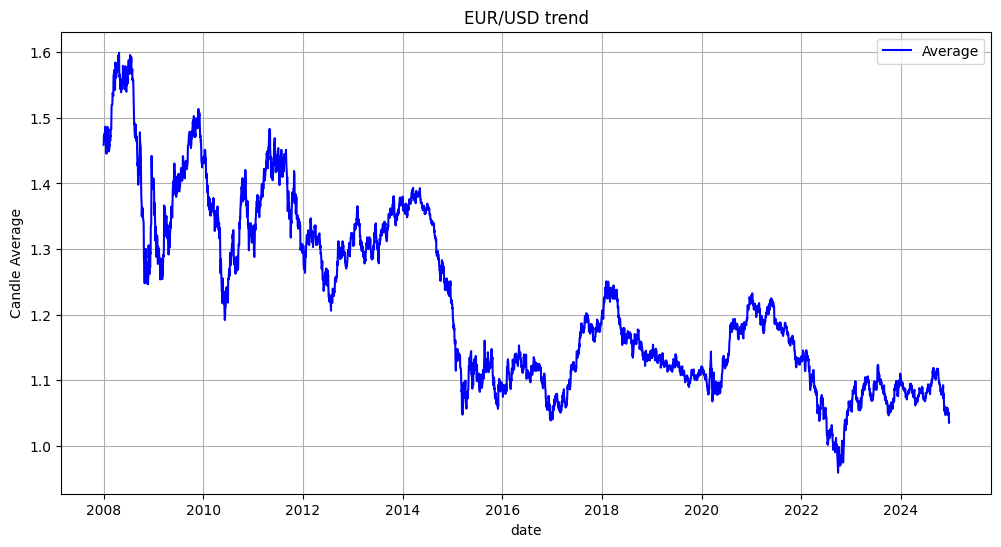

In [6]:
data['Date'] = pd.to_datetime(data['Date'], format='%d.%m.%Y %H:%M:%S.%f')
data['Day'] = data['Date'].dt.date
daily_data = data.groupby('Day').first().reset_index()  # اولین نمونه هر روز

# 4. رسم Line Plot برای Close
plt.figure(figsize=(12, 6))
plt.plot(daily_data['Date'], daily_data['Average'], label='Average', color='blue')

# 5. تنظیمات نمودار
plt.title('EUR/USD trend')
plt.xlabel('date')
plt.ylabel('Candle Average')
plt.legend()
plt.grid(True)

# 6. نمایش
plt.show()

In [ ]:
data.columns

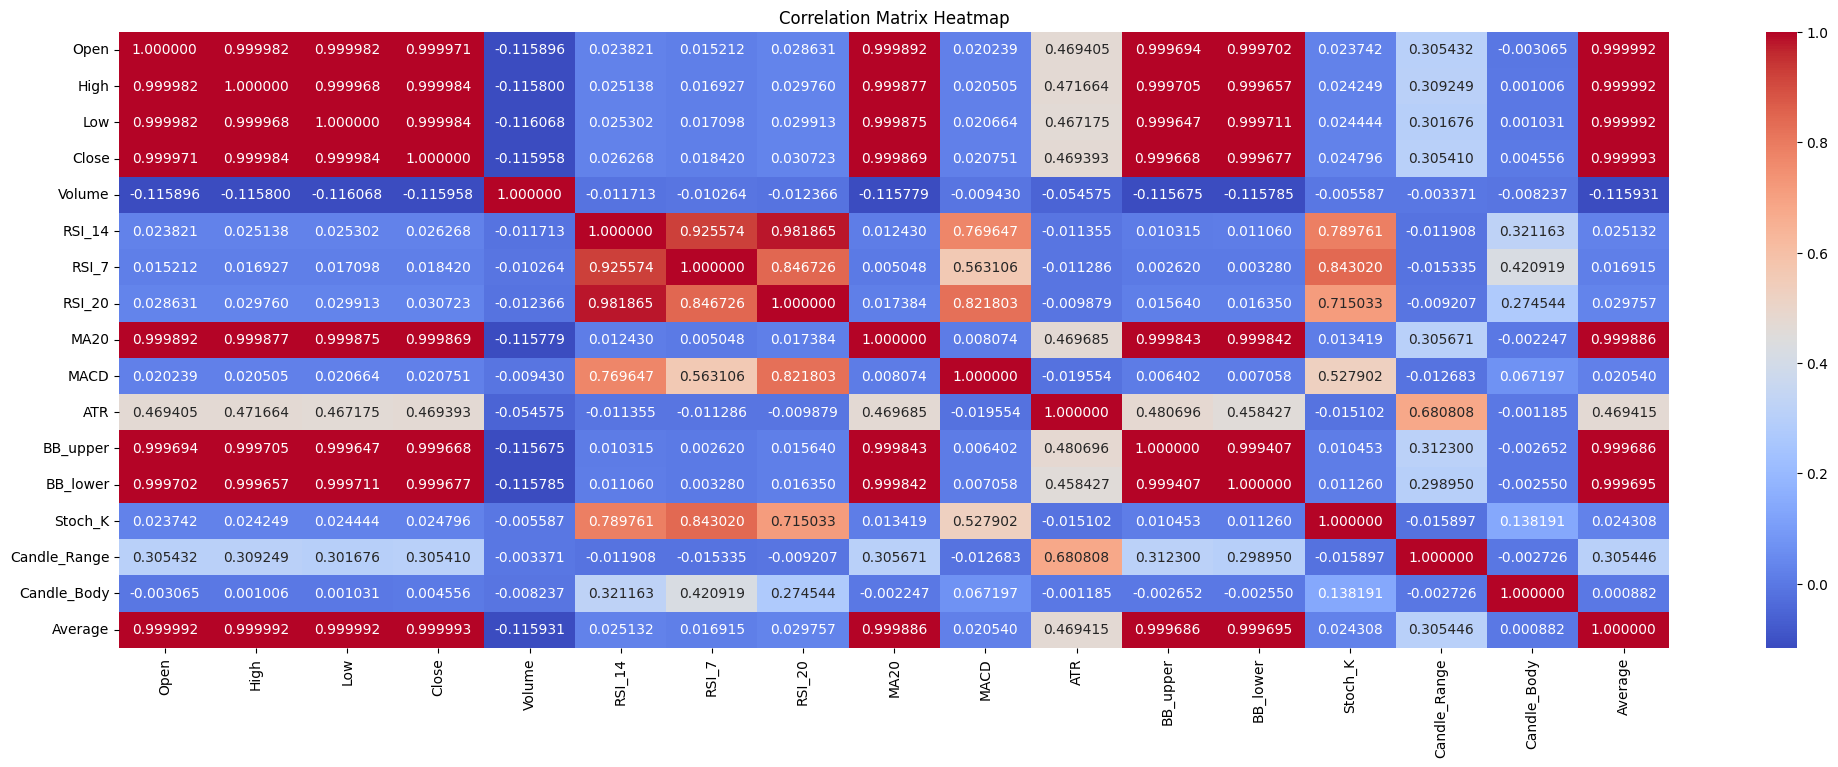

In [8]:
import seaborn as sns
correlation_matrix = data[['Open', 'High', 'Low', 'Close', 'Volume', 'RSI_14', 'RSI_7',
       'RSI_20', 'MA20', 'MACD', 'ATR', 'BB_upper', 'BB_lower', 'Stoch_K',
       'Candle_Range', 'Candle_Body', 'Average']].corr()
plt.figure(figsize=(25, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".6f")
plt.title('Correlation Matrix Heatmap')
plt.show()

In [7]:
input_features = ['Candle_Range','Average','ATR']
scalers_inputs = {col: MinMaxScaler() for col in input_features}
scaled_inputs = np.array([scalers_inputs[col].fit_transform(data[col].values.reshape(-1, 1)) for col in input_features])
scaled_inputs = np.transpose(scaled_inputs, (1, 0, 2))

# 3. انتخاب تارگت (OHLC)
output_features = ['Average']
scalers_outputs = {col: MinMaxScaler() for col in output_features}
scaled_outputs = np.array([scalers_outputs[col].fit_transform(data[col].values.reshape(-1, 1)) for col in output_features])
scaled_outputs = np.transpose(scaled_outputs, (1, 0, 2))

In [8]:
def create_sequences(inputs, outputs, seq_length):
    X, y = [], []
    for i in range(len(inputs) - seq_length):
        X.append(inputs[i:i + seq_length])
        y.append(outputs[i + seq_length])  # 4 مقدار OHLC تایم‌فریم بعدی
    return np.array(X), np.array(y)

seq_length = 90
X, y = create_sequences(scaled_inputs, scaled_outputs, seq_length)

In [9]:
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1)
X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

print("تعداد نمونه‌های Train:", len(X_train))
print("تعداد نمونه‌های Validation:", len(X_val))
print("تعداد نمونه‌های Test:", len(X_test))

تعداد نمونه‌های Train: 169444
تعداد نمونه‌های Validation: 21180
تعداد نمونه‌های Test: 21182


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# ایجاد مدل LSTM بهینه‌شده
model = Sequential([
    LSTM(150, return_sequences=True, input_shape=(90, len(input_features))),  # افزایش Sequence Length
    Dropout(0.4),  # افزایش Dropout
    BatchNormalization(),

    LSTM(100, return_sequences=True),
    Dropout(0.4),
    BatchNormalization(),

    LSTM(50, return_sequences=False),
    Dropout(0.4),

    Dense(25, activation='relu'),  # اضافه کردن Dense با ReLU
    Dense(1)  # خروجی یک مقدار عددی
])

optimizer = Adam(learning_rate=0.0005)

# استفاده از Huber Loss به جای MSE
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, 
                    validation_data=(X_val, y_val), callbacks=[early_stop])

Epoch 1/50
5296/5296 ━━━━━━━━━━━━━━━━━━━━ 115s 21ms/step - loss: 0.0104 - mae: 0.0605 - val_loss: 0.0056 - val_mae: 0.0647
Epoch 2/50
5296/5296 ━━━━━━━━━━━━━━━━━━━━ 108s 20ms/step - loss: 6.4704e-04 - mae: 0.0190 - val_loss: 0.0018 - val_mae: 0.0250
Epoch 3/50
5296/5296 ━━━━━━━━━━━━━━━━━━━━ 108s 20ms/step - loss: 3.9704e-04 - mae: 0.0142 - val_loss: 0.0021 - val_mae: 0.0269
Epoch 4/50
5296/5296 ━━━━━━━━━━━━━━━━━━━━ 108s 20ms/step - loss: 1.7888e-04 - mae: 0.0101 - val_loss: 0.0021 - val_mae: 0.0289
Epoch 5/50
5296/5296 ━━━━━━━━━━━━━━━━━━━━ 108s 20ms/step - loss: 1.4198e-04 - mae: 0.0089 - val_loss: 0.0020 - val_mae: 0.0276
Epoch 6/50
5296/5296 ━━━━━━━━━━━━━━━━━━━━ 108s 20ms/step - loss: 1.0465e-04 - mae: 0.0077 - val_loss: 0.0018 - val_mae: 0.0238
Epoch 7/50
5296/5296 ━━━━━━━━━━━━━━━━━━━━ 108s 20ms/step - loss: 9.5280e-05 - mae: 0.0074 - val_loss: 0.0018 - val_mae: 0.0254
Epoch 8/50
5296/5296 ━━━━━━━━━━━━━━━━━━━━ 108s 20ms/step - loss: 8.5441e-05 - mae: 0.0069 - val_loss: 0.0018 - val_

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss in training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE in training')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [ ]:
# 9. پیش‌بینی
predictions = model.predict(X_test)

# 10. برگردوندن به مقیاس اصلی
predictions_open = scalers_outputs['Open'].inverse_transform(predictions[:, 0].reshape(-1, 1))
predictions_high = scalers_outputs['High'].inverse_transform(predictions[:, 1].reshape(-1, 1))
predictions_low = scalers_outputs['Low'].inverse_transform(predictions[:, 2].reshape(-1, 1))
predictions_close = scalers_outputs['Close'].inverse_transform(predictions[:, 3].reshape(-1, 1))

y_test_open = scalers_outputs['Open'].inverse_transform(y_test[:, 0].reshape(-1, 1))
y_test_high = scalers_outputs['High'].inverse_transform(y_test[:, 1].reshape(-1, 1))
y_test_low = scalers_outputs['Low'].inverse_transform(y_test[:, 2].reshape(-1, 1))
y_test_close = scalers_outputs['Close'].inverse_transform(y_test[:, 3].reshape(-1, 1))

# 11. محاسبه معیارها برای هر مقدار
def calculate_metrics(y_true, y_pred, name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\nمعیارهای ارزیابی برای {name}:")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R² Score: {r2}")

calculate_metrics(y_test_open, predictions_open, "Open")
calculate_metrics(y_test_high, predictions_high, "High")
calculate_metrics(y_test_low, predictions_low, "Low")
calculate_metrics(y_test_close, predictions_close, "Close")

# 12. دقت جهت برای Close
correct_directions = np.sum(np.sign(predictions_close[1:] - predictions_close[:-1]) == np.sign(y_test_close[1:] - y_test_close[:-1]))
directional_accuracy = correct_directions / (len(predictions_close) - 1)
print(f"\nدقت جهت برای Close: {directional_accuracy * 100}%")

# 13. رسم پیش‌بینی‌ها
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(y_test_open, label='real', color='blue')
plt.plot(predictions_open, label='predicted', color='red')
plt.title('Open: actual vs predicted')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(y_test_high, label='real', color='blue')
plt.plot(predictions_high, label='predicted', color='red')
plt.title('High: actual vs predicted')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(y_test_low, label='real', color='blue')
plt.plot(predictions_low, label='predicted', color='red')
plt.title('Low: actual vs predicted')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(y_test_close, label='real', color='blue')
plt.plot(predictions_close, label='predicted', color='red')
plt.title('Close: actual vs predicted')
plt.legend()

plt.tight_layout()
plt.show()